<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/video_interpolation/video_inbetweening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Video inbetweening using 3D convolutions

In [ ]:
%pip install -q mediapy

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall
import tempfile
import pathlib
from PIL import Image
import mediapy as media

TEST_DIR = pathlib.Path(tempfile.mkdtemp()) / "bair_robot_pushing_small/softmotion30_44k/test/"

In [2]:
%mkdir -p $TEST_DIR
!wget -nv https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords -O $TEST_DIR/traj_0_to_255.tfrecords

2023-01-20 22:21:41 URL:https://storage.googleapis.com/download.tensorflow.org/data/bair_test_traj_0_to_255.tfrecords [189852160/189852160] -> "/tmp/tmpo01ec04k/bair_robot_pushing_small/softmotion30_44k/test/traj_0_to_255.tfrecords" [1]


In [ ]:
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name='test', gen_kwargs={"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()

Test videos shape [batch_size, start/end frame, height, width, num_channels]:  (16, 2, 64, 64, 3)


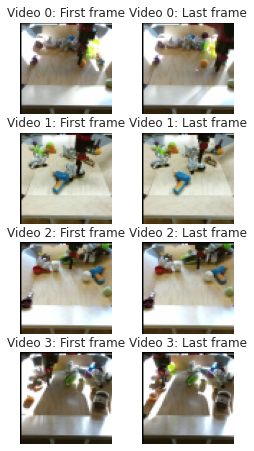

In [4]:
batch_size = 16
ds = builder.as_dataset(split="test")
test_videos = ds.batch(batch_size)
first_batch = next(iter(test_videos))
input_frames = first_batch['image_aux1'][:, ::15]
input_frames = tf.cast(input_frames, tf.float32)

print('Test videos shape [batch_size, start/end frame, height, width, num_channels]: ', 
      input_frames.shape)

def show_frames(input_frames):
  sns.set_style('white')
  plt.figure(figsize=(4, 2*batch_size))

  for i in range(batch_size)[:4]:
    plt.subplot(batch_size, 2, 1 + 2*i)
    plt.imshow(input_frames[i, 0] / 255.0)
    plt.title('Video {}: First frame'.format(i))
    plt.axis('off')
    plt.subplot(batch_size, 2, 2 + 2*i)
    plt.imshow(input_frames[i, 1] / 255.0)
    plt.title('Video {}: Last frame'.format(i))
    plt.axis('off')

show_frames(input_frames)

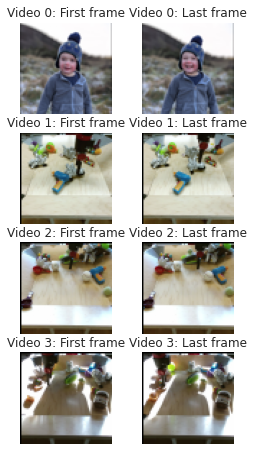

In [21]:
# Changing BAIR dataset frames for our custom images
# They should be squared
img1 = Image.open('one.png').convert('RGB').resize((64, 64))
img2 = Image.open('two.png').convert('RGB').resize((64, 64))

input_frames = np.array(input_frames)
input_frames[0, 0, :, :, :] = np.array(img1)
input_frames[0, 1, :, :, :] = np.array(img2)
input_frames = tf.convert_to_tensor(input_frames)

show_frames(input_frames)

In [ ]:
hub_handle = 'https://tfhub.dev/google/tweening_conv3d_bair/1'
module = hub.load(hub_handle).signatures['default']

##Generate and show the videos

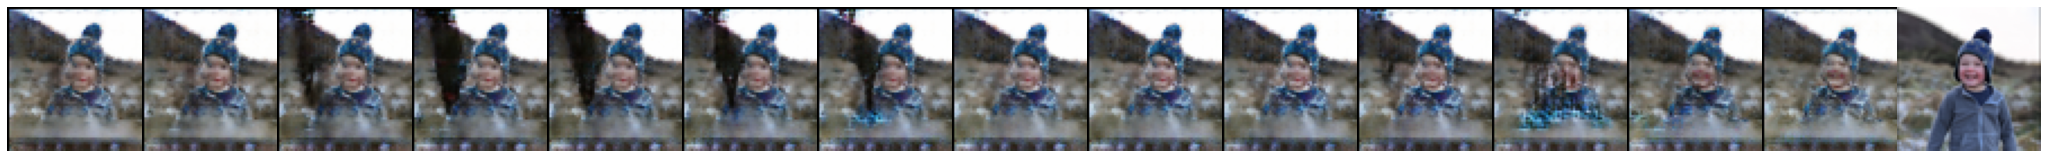

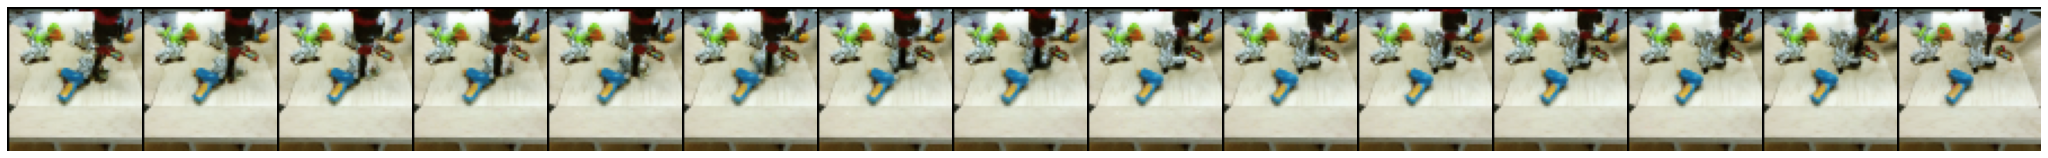

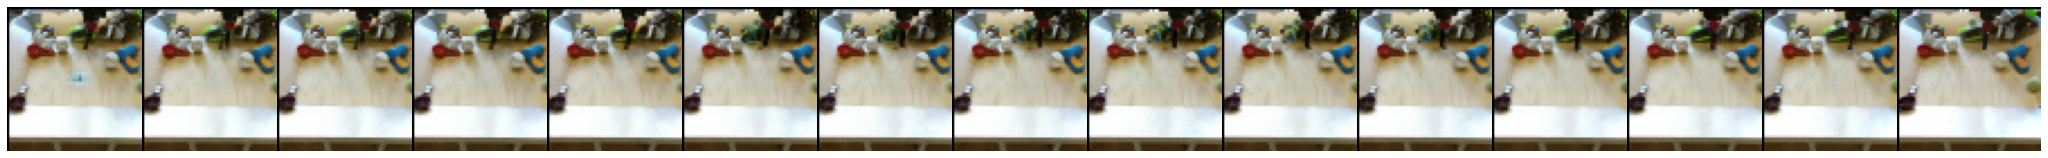

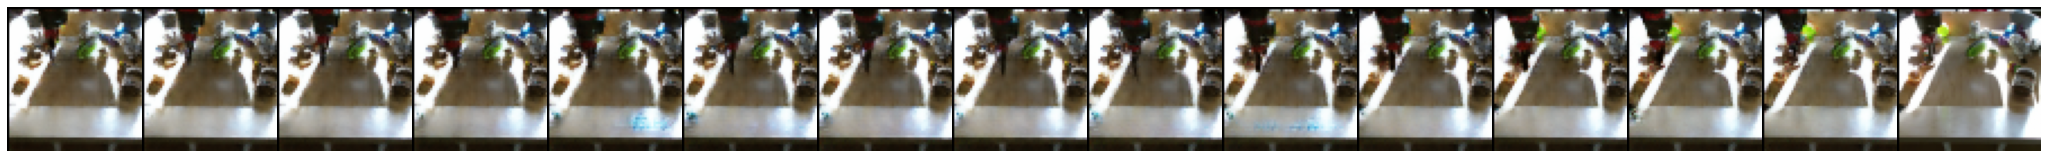

In [22]:
filled_frames = module(input_frames)['default'] / 255.0

# Concatenate start/end frames and the generated filled frames for the new videos.
generated_videos = np.concatenate([input_frames[:, :1] / 255.0, filled_frames, input_frames[:, 1:] / 255.0], axis=1)

for video_id in range(4):
  fig = plt.figure(figsize=(10 * 2, 2))
  for frame_id in range(1, 16):
    ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                      xmargin=0, ymargin=0)
    ax.imshow(generated_videos[video_id, frame_id])
    ax.axis('off')

In [28]:
media.show_video(generated_videos[1], fps=8)